# Qiskit Visualization

# 2.2a Classical feedforward and control flow

Link: https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow



## `if` statement

The `if` statement is used to conditionally perform operations based on the value of a classical bit or register.

In the example below, we apply a Hadamard gate to a qubit and measure it. If the result is 1, then we apply an X gate on the qubit, which has the effect of flipping it back to the 0 state. We then measure the qubit again. The resulting measurement outcome should be 0 with 100% probability.



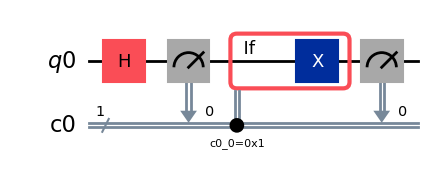

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")

# example output counts: {'0': 1024}

The `with` statement can be given an assignment target which is itself a context manager that can be stored and subsequently used to create an else block, which is executed whenever the contents of the `if` block are *not* executed.

In the example below, we initialize registers with two qubits and two classical bits. We apply a Hadamard gate to the first qubit and measure it. If the result is 1, then we apply a Hadamard gate on the second qubit; otherwise, we apply an X gate on the second qubit. Finally, we measure the second qubit as well.



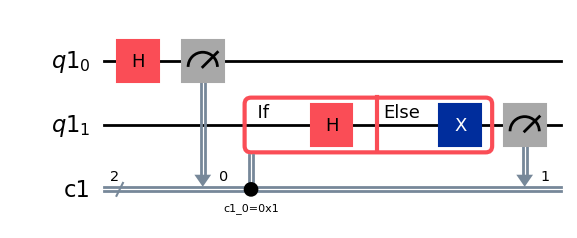

In [2]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)

circuit.draw("mpl")

# example output counts: {'01': 260, '11': 272, '10': 492}

In addition to conditioning on a single classical bit, it's also possible to condition on the value of a classical register composed of multiple bits.

In the example below, we apply Hadamard gates to two qubits and measure them. If the result is `01`, that is, the first qubit is 1 and the second qubit is 0, then we apply an X gate to a third qubit. Finally, we measure the third qubit. Note that for clarity, we chose to specify the state of the third classical bit, which is 0, in the `if` condition. 

#### In the circuit drawing, the condition is indicated by the circles on the classical bits being conditioned on. A black circle indicates conditioning on 1, while a white circle indicates conditioning on 0.



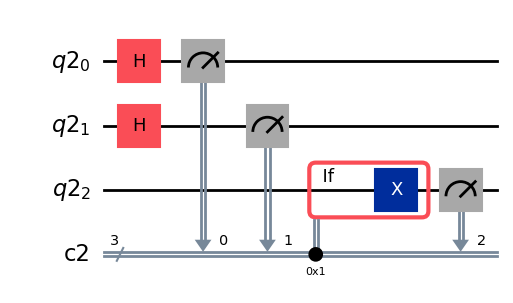

In [3]:
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.if_test((clbits, 0b001)):
    circuit.x(q2)
circuit.measure(q2, c2)

circuit.draw("mpl")

# example output counts: {'101': 269, '011': 260, '000': 252, '010': 243}

## Classical expressions

The Qiskit classical expression module [`qiskit.circuit.classical`](/docs/api/qiskit/circuit_classical) contains an exploratory representation of runtime operations on classical values during circuit execution. Due to hardware limitations, only `QuantumCircuit.if_test()`  conditions are currently supported.



## Find backends that support dynamic circuits

### Dynamic circuits are now available on all backends

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
dc_backends = service.backends(dynamic_circuits=True)
print(dc_backends)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-03 14:48:54,589: Default instance not set. Searching all available instances.


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


## Qiskit Runtime limitations (for reference)

Be aware of the following constraints when running dynamic circuits in Qiskit Runtime.  Note that as new features and improvements are added throughout 2025, some of these limitations will be lifted.

*   Due to the limited physical memory on control electronics, there is also a limit on the number of `if` statements and size of their operands. This limit is a function of the number of broadcasts and the number of broadcasted bits in a job (not a circuit).

    When processing an `if` condition, measurement data needs to be transferred to the control logic to make that evaluation. 
    ### -> A broadcast is a transfer of unique classical data, and broadcasted bits is the number of classical bits being transferred. 
    
    Consider the following:

    ```python
    c0 = ClassicalRegister(3)
    c1 = ClassicalRegister(5)
    ...
    with circuit.if_test((c0, 1)) ...
    with circuit.if_test((c0, 3)) ...
    with circuit.if_test((c1[2], 1)) ...
    ```

    In the previous code example, the first two `if_test`s on `c0` are considered one broadcast because the content of `c0` did not change, and thus does not need to be re-broadcasted. The `if_test` on `c1` is a second broadcast. The first one broadcasts all three bits in `c0` and the second broadcasts just one bit, making a total of four broadcasted bits.

    Currently, if you broadcast 60 bits each time, then the job can have approximately 300 broadcasts. If you broadcast just one bit each time, however, then the job can have 2400 broadcasts.

*   The operand used in an `if_test` statement must be 32 or fewer bits. Thus, if you are comparing an entire `ClassicalRegister`, the size of that `ClassicalRegister` must be 32 or fewer bits. If you are comparing just a single bit from a `ClassicalRegister`, however, that `ClassicalRegister` can be of any size (since the operand is only one bit).

    For example, the "Not valid" code block does not work because `cr` is more than 32 bits.  You can, however, use a classical register wider than 32 bits if you are testing only one bit, as shown in the "Valid" code block.

    <Tabs>
      <TabItem value="Not valid" label="Not valid">
        ```python
           cr = ClassicalRegister(50)
           qr = QuantumRegister(50)
           circuit = QuantumCircuit(qr, cr)
           ...
           circ.measure(qr, cr)
           with circ.if_test((cr, 15)):
              ...
        ```
      </TabItem>

      <TabItem value="Valid" label="Valid">
        ```python
           cr = ClassicalRegister(50)
           qr = QuantumRegister(50)
           circuit = QuantumCircuit(qr, cr)
           ...
           circ.measure(qr, cr)
           with circ.if_test((cr[5], 1)):
              ...
        ```
      </TabItem>
    </Tabs>

*   Nested conditionals are not allowed. For example, the following code block will not work because it has an `if_test` inside another `if_test`:
    <Tabs>
      <TabItem value="Not valid" label="Not valid">
        ```python
           c1 = ClassicalRegister(1, "c1")
           c2 = ClassicalRegister(2, "c2")
           ...
           with circ.if_test((c1, 1)):
            with circ.if_test(c2, 1)):
             ...
        ```
      </TabItem>

      <TabItem value="Valid" label="Valid">
        ```python
        cr = ClassicalRegister(2)
        ...
        with circuit.if_test((cr, 0b11)):
          ...
        ```
      </TabItem>
    </Tabs>

*   Having `reset` or measurements inside conditionals is not supported.

*   Arithmetic operations are not supported.

*   See the [OpenQASM 3 feature table](/docs/guides/qasm-feature-table) to determine which OpenQASM 3 features are supported on Qiskit and Qiskit Runtime.

*   When OpenQASM 3 (instead of `QuantumCircuit`) is used as the input format to pass circuits to Qiskit Runtime primitives, only instructions that can be loaded into Qiskit are supported. Classical operations, for example, are not supported because they cannot be loaded into Qiskit. See [Import an OpenQASM 3 program into Qiskit](/docs/guides/interoperate-qiskit-qasm3#import-an-openqasm-3-program-into-qiskit) for more information on loading an OpenQASM 3 program into Qiskit.

